# LGSSM - Object Tracking Demo - JAX

In this demo, we will be looking at how we can do object tracking via the Linear Gaussian State Space Model (LGSSM).

In [39]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))



In [40]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random
from functools import partial

import jaxkf._src.lgssm as lgssm
from jaxkf._src.viz import plot_tracking_values
from jaxkf._src.utils import calculate_error_bounds

import matplotlib.pyplot as plt
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System

### State Transition Dynamics

We assume that we can fully describe the state when we have the `(x,y)` coordinates of the position and the `(x,y)` velocity. So we can write this as:

$$
\mathbf{z}_t = 
\begin{bmatrix}
z_t^1 \\ z_t^2 \\ \dot{z}_t^1 \\ \dot{z}_t^2
\end{bmatrix}
$$

where $z_t^d$ is the coordinate of the position and $\dot{z}^d$ is the velocity. 

We can describe the dynamics of the system using the following system of equations:

$$
\begin{aligned}
z_t^1 &= z_{t-1}^1 + \Delta_t \dot{z}_t^1 + \epsilon_t^1 \\
z_t^2 &= z_{t-1}^2 + \Delta_t \dot{z}_t^2 + \epsilon_t^2 \\
\dot{z}_t^1 &= \dot{z}_{t-1}^1 + \epsilon_t^3 \\
\dot{z}_t^2 &= \dot{z}_{t-1}^2 + \epsilon_t^4 \\
\end{aligned}
$$

This is a very simple formulation which takes a first order approximation to the change in position based on speed and we also assume constant velocity. Note, we also include some noise because we assume that some of the dynamics are noisy, i.e. there are random acceleration and position changes in the model. 


We can also put this into matrix formulation like so:

$$
\mathbf{z}_t = \mathbf{A}_t \mathbf{z}_{t-1} + \boldsymbol{\epsilon}_t
$$

where:

$$
\mathbf{A}_t = 
\begin{bmatrix}
1 & 0 & \Delta_t & 0 \\
0 & 1 & 0 & \Delta_t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \;\; \mathbf{A}_t \in \mathbb{R}^{4\times 4}
$$

---
### Emissions Model

We can only fully observe the locations (not the velocities). So this will be a lower dimensional vector of size 2-D. The system of equations are as follows:

$$
\begin{aligned}
x_t^1 &= z_t^1 + \delta_t^1 \\
x_t^2 &= z_t^2 + \delta_t^2 \\
\end{aligned}
$$

This is a very simple model where we assume we can extract the direct positions (plus some noise) from the state.

We can write this in an abbreviated matrix formulation:

$$
\mathbf{x}_t = \mathbf{C}_t \mathbf{z}_t + \delta_t
$$

where:

$$
\mathbf{C}_t = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}, \;\; \mathbf{C}_t \in \mathbb{R}^{2 \times 4}
$$


In [41]:
key = random.PRNGKey(314)
timesteps = 15
Δt = 10.0
transition_matrix = jnp.array([
    [1, 0, Δt, 0],
    [0, 1, 0, Δt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

observation_matrix = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = transition_matrix.shape
observation_size, _ = observation_matrix.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 10.0
# Prior parameter distribution
mu0 = jnp.array([8, 10, 1, 0]).astype(float)
Sigma0 = jnp.eye(state_size) * 1.0

### Distributions

In [42]:
# initia
transition_noise = lgssm.MultivariateNormal(jnp.zeros(state_size), Q)


observation_noise = lgssm.MultivariateNormal(jnp.zeros(observation_size), R)

initial_state_prior = lgssm.MultivariateNormal(mu0, Sigma0)

## Model

In [43]:
kf_model = lgssm.LinearGaussianStateSpaceModel(
    transition_matrix, transition_noise,
    observation_matrix, observation_noise,
    initial_state_prior
)

## Example - Single Trajectory

## Observations

In [44]:
%%time
n_samples = 1
key = random.PRNGKey(1233)
state_samples, obs_samples = kf_model.sample(seed=key, sample_shape=n_samples, num_timesteps=timesteps)

CPU times: user 491 ms, sys: 19.5 ms, total: 510 ms
Wall time: 518 ms


In [45]:
# %%time
# n_samples = 1
# sample_initial_state = False

# key = random.PRNGKey(1233)
# state_samples, obs_samples = kf_model.sample(
#     key=key, 
#     n_samples=n_samples, 
#     sample_intial_state=sample_initial_state
# )



In [46]:
state_samples.shape, obs_samples.shape

((1, 15, 4), (1, 15, 2))

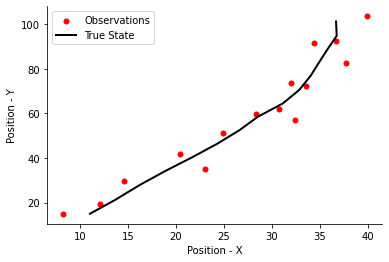

In [47]:
fig, ax = plt.subplots()

# plot the observations
ax.scatter(obs_samples[0, ..., 0], obs_samples[0, ..., 1], marker=".", s=100, color="red", label="Observations")

# plot the estimated states
ax.plot(state_samples[0, ..., 0], state_samples[0, ..., 1], "k-", linewidth=2, label="True State")

ax.set(xlabel="Position - X", ylabel="Position - Y")

plt.legend()
plt.show()

### Forward Pass (Filtering)

In [48]:
%%time

log_probs, mus, sigmas, mus_cond, sigmas_cond = kf_model.forward_filter(obs_samples)


mus.shape, sigmas.shape

CPU times: user 522 ms, sys: 6.64 ms, total: 529 ms
Wall time: 539 ms


((1, 15, 4), (1, 15, 4, 4))

In [49]:
pred_var = jnp.diagonal(sigmas.squeeze(), axis1=1, axis2=2)
pred_var.shape

(15, 4)

In [50]:
lb, ub = calculate_error_bounds(mus.squeeze(), pred_var, 1.96)

### Viz

#### Filtered Dist

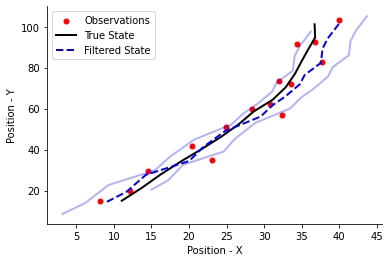

In [51]:
fig, ax = plt.subplots()

# plot the observations
ax.scatter(obs_samples[0, ..., 0], obs_samples[0, ..., 1], marker=".", s=100, color="red", label="Observations")

# plot the estimated states
ax.plot(state_samples[0, ..., 0], state_samples[0, ..., 1], "k-", linewidth=2, label="True State")

# plot the filtered dist
ax.plot(mus[0, ..., 0], mus[0, ..., 1], linestyle="--", color="blue", linewidth=2, label="Filtered State")
ax.plot(lb[...,0], lb[..., 1], linestyle="-", color="blue", linewidth=2, alpha=0.3)
ax.plot(ub[...,0], ub[...,1], linestyle="-", color="blue", linewidth=2, alpha=0.3)

ax.set(xlabel="Position - X", ylabel="Position - Y")

plt.legend()
plt.show()

### Backward Pass (Smoothing)

In [52]:
%%time

mus_smooth, sigmas_smooth = kf_model.backward_smoothing_pass(mus, sigmas, mus_cond, sigmas_cond)

CPU times: user 555 ms, sys: 7.64 ms, total: 563 ms
Wall time: 568 ms


#### Posterior Marginals (Alternative)

In [53]:
%%time

mu_hist_smooth, Sigma_hist_smooth = kf_model.posterior_marginals(obs_samples)

CPU times: user 965 ms, sys: 8.7 ms, total: 974 ms
Wall time: 971 ms


In [54]:
np.testing.assert_array_equal(mu_hist_smooth, mus_smooth)
np.testing.assert_array_equal(sigmas_smooth, Sigma_hist_smooth)

In [55]:
pred_var = jnp.diagonal(sigmas_smooth.squeeze(), axis1=1, axis2=2)
pred_var.shape

(15, 4)

In [56]:
lb, ub = calculate_error_bounds(mus_smooth.squeeze(), pred_var, 1.96)

### Visualization

#### Smoothed Distribution

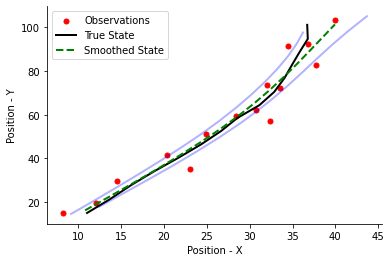

In [57]:
fig, ax = plt.subplots()

# plot the observations
ax.scatter(obs_samples[0, ..., 0], obs_samples[0, ..., 1], marker=".", s=100, color="red", label="Observations")

# plot the estimated states
ax.plot(state_samples[0, ..., 0], state_samples[0, ..., 1], "k-", linewidth=2, label="True State")

# plot the filtered dist
ax.plot(mus_smooth[0, ..., 0], mus_smooth[0, ..., 1], linestyle="--", color="green", linewidth=2, label="Smoothed State")
ax.plot(lb[...,0], lb[..., 1], linestyle="-", color="blue", linewidth=2, alpha=0.3)
ax.plot(ub[...,0], ub[...,1], linestyle="-", color="blue", linewidth=2, alpha=0.3)


ax.set(xlabel="Position - X", ylabel="Position - Y")

plt.legend()
plt.show()

### Tracking - Original

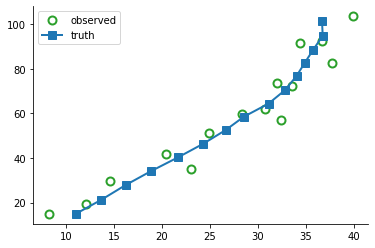

In [58]:
fig, axs = plt.subplots()
axs.plot(
    obs_samples[0, :, 0], obs_samples[0, :, 1], 
    marker="o", linewidth=0,
     markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
axs.plot(
    state_samples[0, :, 0], state_samples[0, :, 1], 
    linewidth=2, label="truth", marker="s", markersize=8)
axs.legend()
# axs.axis("equal")
# pml.savefig("kalman_tracking_truth.png")
plt.show()

#### Tracking - Filtered

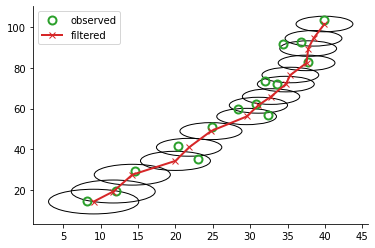

In [59]:
fig, axs = plt.subplots()
axs = plot_tracking_values(obs_samples.squeeze(), mus.squeeze(), sigmas.squeeze(), "filtered", axs)
# pml.savefig("kalman_tracking_filtered.png")
plt.show()

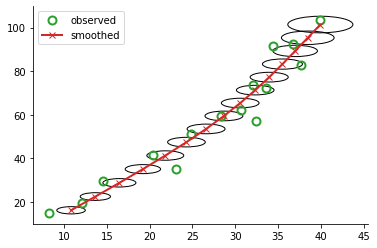

In [60]:
fig, axs = plt.subplots()
axs = plot_tracking_values(obs_samples.squeeze(), mus_smooth.squeeze(), sigmas_smooth.squeeze(), "smoothed", axs)
# pml.savefig("kalman_tracking_smoothed.png")
plt.show()

### Losses

#### Norm

In [61]:
l2_filter = jnp.linalg.norm(state_samples[0, :, :2] - mus[0, :, :2], 2)
l2_smooth = jnp.linalg.norm(state_samples[0, :, :2] - mus_smooth[0, :, :2], 2)

print(f"L2-filter: {l2_filter:0.4f}")
print(f"L2-smooth: {l2_smooth:0.4f}")

L2-filter: 9.0962
L2-smooth: 4.1148


#### NLL

In [62]:
log_probs.shape

(1, 15)

In [63]:
marginal_log_likelihood = - jnp.mean(log_probs)

print(f"NLL: {marginal_log_likelihood:0.4f}")

NLL: 6.2285


## Example - Multiple Trajectories

### Draw Samples

In [64]:
%%time

n_samples = 5
key = random.PRNGKey(1233)
state_samples, obs_samples = kf_model.sample(seed=key, sample_shape=n_samples, num_timesteps=timesteps)


CPU times: user 684 ms, sys: 7.32 ms, total: 692 ms
Wall time: 691 ms


In [65]:
state_samples.shape, obs_samples.shape

((5, 15, 4), (5, 15, 2))

#### Viz - Different Trajectories

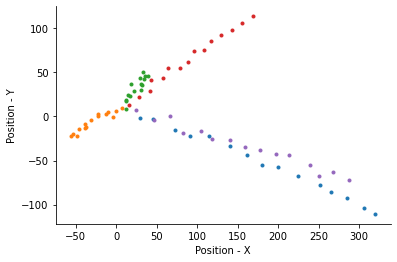

In [66]:
fig, ax = plt.subplots()

ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

### Forward Filter

In [67]:
%%time

log_probs, mus, sigmas, mus_cond, sigmas_cond = kf_model.forward_filter(obs_samples)


mus.shape, sigmas.shape

CPU times: user 490 ms, sys: 4.98 ms, total: 495 ms
Wall time: 494 ms


((5, 15, 4), (5, 15, 4, 4))

#### Viz - Filtered Dist

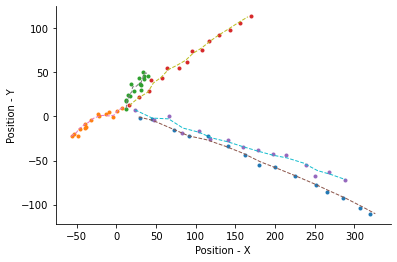

In [68]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot filtered
# ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=3, label="Filtered")
ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=1, label="Filtered")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

#### Viz - Filtered (Conditioned)

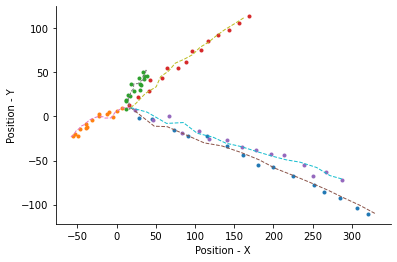

In [69]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot filtered
# ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=3, label="Filtered")
ax.plot(mus_cond[..., 0].T, mus_cond[..., 1].T, "--", linewidth=1, label="Filtered")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

### Backwards Filter

In [70]:
%%time

mus_smooth, sigmas_smooth = kf_model.posterior_marginals(obs_samples)

CPU times: user 1.09 s, sys: 9.53 ms, total: 1.1 s
Wall time: 1.1 s


#### Viz - Smoothed

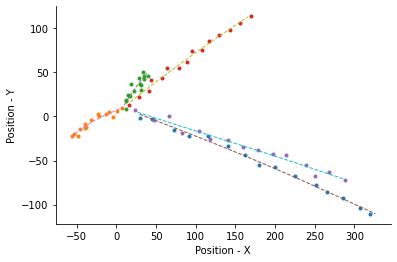

In [71]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot smooth
ax.plot(mus_smooth[..., 0].T, mus_smooth[..., 1].T, "--", linewidth=1, label="Smoothed")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

#### Viz - Smoothed & Filtered

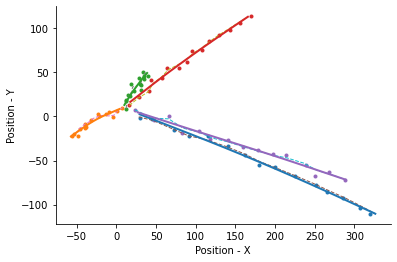

In [72]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot filtered
ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=1, label="Filtered")

# plot smoothed
ax.plot(mus_smooth[..., 0].T, mus_smooth[..., 1].T, "-", linewidth=2, label="Smoothed")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

### Losses

#### Norms

In [73]:
fn = lambda x, y: jnp.linalg.norm(x-y, ord=2)

In [74]:
# calculate for each sample
l2_filter = jax.vmap(fn, in_axes=(0, 0))(state_samples[..., :2], mus[..., :2])
l2_smooth = jax.vmap(fn, in_axes=(0, 0))(state_samples[..., :2], mus_smooth[..., :2])

In [75]:
print(f"L2-filter: {l2_filter.mean():0.4f}")
print(f"L2-smooth: {l2_smooth.mean():0.4f}")

L2-filter: 10.2253
L2-smooth: 7.6399


#### NLL

In [76]:
log_probs.shape

(5, 15)

In [38]:
marginal_log_likelihood = - jnp.mean(log_probs)

print(f"NLL: {marginal_log_likelihood:0.4f}")

NLL: 11.0377
